In [1]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging
from tqdm import tqdm
import sklearn
import os
import torch


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
torch.multiprocessing.set_sharing_strategy("file_system")

2023-03-10 06:44:34.718102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Pure Dataset
train_df = pd.read_csv('../../data/dataset/train.csv', header=None, encoding='utf-8')
test_df = pd.read_csv('../../data/dataset/test.csv', header=None, encoding='utf-8')
val_df = pd.read_csv('../../data/dataset/val.csv', header=None, encoding='utf-8')
all_df = pd.read_csv('../../data/dataset/dataset.csv', header=None, encoding='utf-8')

In [8]:
# Combined Dataset
train_df = pd.read_csv('../../data/dataset/train_combined.csv', header=None, encoding='utf-8')
test_df = pd.read_csv('../../data/dataset/test_combined.csv', header=None, encoding='utf-8')
val_df = pd.read_csv('../../data/dataset/val_combined.csv', header=None, encoding='utf-8')
all_df = pd.read_csv('../../data/dataset/dataset_combined.csv', header=None, encoding='utf-8')

In [3]:
train_df.columns = ["text", "labels"]
test_df.columns = ["text", "labels"]
val_df.columns = ["text", "labels"]
all_df.columns = ["text", "labels"]
train_df['labels'] = train_df['labels'] + 2
test_df['labels'] = test_df['labels'] + 2
val_df['labels'] = val_df['labels'] + 2
all_df['labels'] = all_df['labels'] + 2

In [4]:
%env CUDA_VISIBLE_DEVICES=4,5,6,7
%env OMP_NUM_THREADS=32
%env OPENBLAS_NUM_THREADS=32
%env MKL_NUM_THREADS=32
%env VECLIB_MAXIMUM_THREADS = 32
%env NUMEXPR_NUM_THREADS = 32
torch.set_num_threads(32)

env: CUDA_VISIBLE_DEVICES=4,5,6,7


In [5]:
num_labels = 6
model_args = ClassificationArgs()
model_args.num_train_epochs = 20
model_args.overwrite_output_dir = True
model_args.n_gpu = 6
model_args.no_cache = False
model_args.train_batch_size = 384
model_args.output_dir = '/home/data/xuyijie/Documents/AllsidesScraper/news-title-bias/notebooks/02.Transformers/Models/outputs-xlmroberta-%sgpu-batchsize%s-%sepoch_%slabel/'%(str(model_args.n_gpu), str(model_args.train_batch_size), str(model_args.num_train_epochs), str(num_labels))
model_args.reprocess_input_data = False

# Save Models

model_args.save_steps = -1
model_args.save_model_every_epoch = True
model_args.save_eval_checkpoints = False

# Evaluation

model_args.best_model_dir = model_args.output_dir + 'best-model'
model_args.evaluate_during_training = False
model_args.evaluate_during_training_verbose = False
model_args.eval_batch_size = 1

# Early Stopping

model_args.use_early_stopping = False
model_args.early_stopping_delta = 0.01
model_args.early_stopping_metric = "mcc"
model_args.early_stopping_metric_minimize = False
model_args.early_stopping_patience = 5
model_args.evaluate_during_training_steps = 1000

# Create a ClassificationModel
model = ClassificationModel(
    "xlmroberta", 
    'xlm-roberta-large',
    num_labels=num_labels,
    args=model_args,
)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out

In [ ]:
# Train the model
import sklearn
model.train_model(train_df, eval_df=val_df, acc=sklearn.metrics.accuracy_score, mcc=sklearn.metrics.matthews_corrcoef)

# Evaluation

In [ ]:
# Evaluation by Folders.

# Get Folders.
folder = '/home/data/xuyijie/Documents/AllsidesScraper/news-title-bias/notebooks/02.Transformers/Models/outputs-xlmroberta-6gpu-batchsize384-20epoch_6label' + '/'
dir_list = []
for root, dirs, files in os.walk(folder):
    dir_list.append(dirs)
dirs = dir_list[0]

# Use numbers of GPU.
model_args = ClassificationArgs()
model_args.n_gpu = 4
model_args.eval_batch_size = 16384

model_args.reprocess_input_data = False
model_args.no_cache = False

result_df = []
for dir in tqdm(dirs):
    model = ClassificationModel(
        "xlmroberta", 
        os.path.join(folder,dir),
        num_labels=6,
        args=model_args,
        use_cuda=True
    )
    result, model_outputs, wrong_predictions = model.eval_model(all_df)
    result_df.append({'dir': dir, 'accuracy': sklearn.metrics.accuracy_score(all_df['labels'], model_outputs.argmax(axis=1)), 'confusion_matrix': sklearn.metrics.confusion_matrix(all_df['labels'], model_outputs.argmax(axis=1))})
result_df = pd.DataFrame(result_df)

In [5]:
# Evaluation for one model.

# Use numbers of GPU.
model_args = ClassificationArgs()
model_args.n_gpu = 5
model_args.eval_batch_size = 16384

model_args.reprocess_input_data = True
model_args.no_cache = True

result_df = []

model = ClassificationModel(
    "xlmroberta", 
    '/home/data/xuyijie/Documents/AllsidesScraper/news-title-bias/notebooks/02.Transformers/Models/outputs-xlmroberta-6gpu-batchsize400-20epoch_5label/checkpoint-9360-epoch-20',
    num_labels=5,
    args=model_args,
    use_cuda=True
)
result, model_outputs = model.predict(all_df['text'].tolist())
result_df.append({'dir': dir, 'accuracy': sklearn.metrics.accuracy_score(all_df['labels'], model_outputs.argmax(axis=1)), 'confusion_matrix': sklearn.metrics.confusion_matrix(all_df['labels'], model_outputs.argmax(axis=1))})
result_df = pd.DataFrame(result_df)

/home/data/xuyijie/anaconda3/envs/torch/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:486: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/233570 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/15 [00:00<?, ?it/s]

/home/data/xuyijie/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [8]:
list(result_df['confusion_matrix'])

[array([[25784,    51,    31,    20,    68],
        [   79, 53138,   224,    37,    54],
        [   43,    75, 75804,    32,    69],
        [   33,    69,    61, 32276,   116],
        [   44,    49,   101,    72, 45240]])]

In [25]:
# Use numbers of GPU.
model_args = ClassificationArgs()
model_args.n_gpu = 4
model_args.eval_batch_size = 16384

model_args.reprocess_input_data = False
model_args.no_cache = False

model = ClassificationModel(
        "xlmroberta", 
        '/home/data/xuyijie/Documents/AllsidesScraper/news-title-bias/notebooks/02.Transformers/Models/outputs-xlmroberta-6gpu-batchsize400-20epoch_5label/checkpoint-9360-epoch-20',
        num_labels=5,
        args=model_args
    )

/home/data/xuyijie/anaconda3/envs/torch/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:486: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/233570 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

/home/data/xuyijie/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


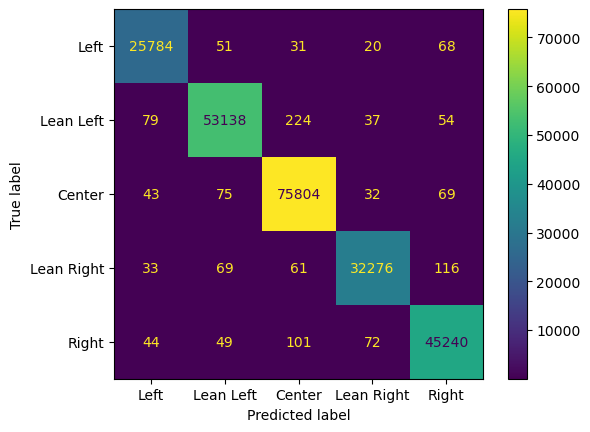

In [27]:
import matplotlib.pyplot as plt
preds, model_outputs = model.predict(all_df['text'].tolist())
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(all_df['labels'], model_outputs.argmax(axis=1)), display_labels=['Left', 'Lean Left', 'Center', 'Lean Right', 'Right']).plot()

In [30]:
!mkdir Classification_Results

(23357,)

In [26]:
pd.DataFrame(preds['label'])

,0
0,0
1,0
2,1
3,1
4,4
...,...
233565,1
233566,1
233567,0
233568,0


In [17]:
model_outputs.shape

(23357, 5)

In [9]:
all_df

,0,1
0,Summary US announces new 185 bln military aid ...,0
1,In an extraordinary facetoface meeting at the ...,-1
2,Ukrainian President Volodymyr Zelenskyy on Wed...,2
3,A patient is turned away from the emergency ro...,-1
4,Washington Two Americans who had been detai...,-2
...,...,...
283565,soo cool i wont but i9 cant,3
283566,Just got megans birthday gifts I think i did g...,3
283567,Good morning Avi and a great week to you too ...,3
283568,you look so cute love it xoxo,3


In [11]:
wrong_predictions

[{'guid': 3, 'text_a': 'The news could not have reached Remira Alarsa at a worse moment  Since leaving her home in Venezuela last month the former teacher her husband and nephew had trekked thousands of miles through seven countries determined to resettle in the US  only to be robbed of their savings in Guatemala  Soon afterwards she learned that it might all have been for nothing  On 12 October the Biden administration announced that it would deport Venezuelan migrants to Mexico under a previously obscure public health law Title 42 which was used for summary expulsions by the Trump administration and has been continued under Joe Biden  Venezuelans arriving at the southern border will no longer be able to join their families in the US while they wait their turn in the asylum process but will be forced to languish in Mexico where they are routinely targeted for rape robbery and extortion  The abrupt implementation of Title 42 for Venezuelans has created an arbitrary cutoff and left tens

In [15]:
import sklearn
model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)
# simpletransformers.classification.classification_model:{'mcc': 0.9742210292375231, 'eval_loss': 0.13528874290077947, 'acc': 0.9800916213554823}

INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_roberta_128_6_2


Running Evaluation:   0%|          | 0/22920 [00:00<?, ?it/s]

|              Experiment              |        mcc         |        acc         |      eval_loss      |
| :----------------------------------: | :----------------: | :----------------: | :-----------------: |
|               10-epoch               | 0.9742210292375231 | 0.9800916213554823 | 0.13528874290077947 |
| 4gpu-batchsize256-50epoch/best-model | 0.9714815062325393 | 0.9779509354797277 | 0.06884455568578145 |



In [ ]:
import sklearn
model.eval_model(test_df, acc=sklearn.metrics.confusion_matrix)
# simpletransformers.classification.classification_model:{'mcc': 0.9742210292375231, 'eval_loss': 0.13528874290077947, 'acc': array([
#       [2562,   15,    8,    9,   17],
#       [  15, 5366,   63,   18,   29],
#       [   8,   33, 7413,   14,   29],
#       [   6,   21,   40, 3078,   52],
#       [  10,   12,   41,   25, 4473]])}

|              Experiment              |        Confusion Matrix         |
| :----------------------------------: | :----------------: |
|               10-epoch               | [2562,   15,    8,    9,   17], [  15, 5366,   63,   18,   29], [   8,   33, 7413,   14,   29], [   6,   21,   40, 3078,   52],  [  10,   12,   41,   25, 4473] |
| 4gpu-batchsize256-50epoch/best-model | [2576,    7,    8,    5,   26], [  19, 5213,   52,   27,   63], [  14,   23, 7518,   11,   65], [   5,   12,   21, 3023,  106], [   3,   10,   14,   24, 4512] |



In [17]:
model.predict([
    "The typical mantra from healthcare experts when ringing in the new year usually centers around commitments to exercise more and lose weight. Although important, there may be a new year resolution that could be more impactful for your health. What about investing in your health by simply visiting your primary care doctor. Sounds simple, but this could literally be the difference between your life and death. According to Statnews, primary care visits are down 10.3% across America when compared to pre-pandemic levels. This means 1 in 10 Americans who usually come to see their primary doctor for a general checkup have not done so since the Covid-19 pandemic started. This also means that routine screening for important diagnoses like diabetes, cardiovascular disease, and cancer have been delayed for these individuals. This ultimately will hinder effective treatment of these diseases that could have been prevented had they been detected. According to new research, only 14% of cancers that occur in the United States are being detected by screening. This means that 6 of 7 cancers are discovered when symptoms have already occurred. Screening tests are available for five different cancers- lung, breast, colorectal, cervical, and prostate. If screening tests are used less by the general public, then less cancers will be found at an early stage when they are potentially treatable. Too often, cancers get detected when it is too late, symptoms are present and there is limited treatment that can be done to save one’s life. As an example, screening for breast cancer should occur for most women at the age of 40, according to the American College of Radiology. Breast cancer is the most common cancer in women in America, and the second leading cause of cancer death in women, after lung cancer. According to the American Cancer Society, 43,250 women died from breast cancer in 2022. Breast cancer is screened for by mammograms, which are non-invasive x-rays that check the breast for any abnormalities, specifically cancer. According to the American College of Radiology, mammograms can detect cancer much earlier than they can be felt by the hand. In addition, annual screening with mammograms has reduced deaths from breast cancer in the US by nearly 40% dating back to the 1990’s. The success of early cancer screening is at risk given less Americans are going to their primary care doctors and less individuals are getting screened for various cancers. According to a study in JAMA Network, screening rates for breast, cervical, and colorectal cancer have all declined since the start of the Covid-19 pandemic. Furthermore, only 6% of those eligible for getting screened for lung cancer are actually showing up for their low dose CT chest examination, the screening study for lung cancer. This means that 94% of Americans who are at risk for developing lung cancer, the deadliest cancer in America, are not getting routinely screened for it."
    ])

INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_roberta_128_5_2


  0%|          | 0/2920 [00:00<?, ?it/s]

/home/yijiexu/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


ValueError: could not broadcast input array from shape (8,5) into shape (1,5)

In [11]:
model

In [ ]:
predictions